In [128]:
#Downloads what we need for pytorch, the second one is for working with GPU (although I'm not sure if that's 100% correct)

%pip install tensorflow
%pip install tensorflow-datasets
%pip install torch torchvision torchaudio
%pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
%pip -q install tensorflow-datasets pillow torchvision matplotlib
%pip install einops


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu118
Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [129]:
import tensorflow_datasets as tfds #this allows us to get the dataset directly from tensorflow (so CLIC)
#Lowkey the best option might be to install it on our PC/Laptops but like this is technically an option lmao
import numpy as np #numpy lol
from PIL import Image #lets us convert numpy arrays into images
import torch, torch.nn as nn #import numpy

import torch.nn.functional as F #this one is to unfold the patches from their mid token form (for bug testing the encoder basically)

from torchvision import transforms #easy conversion into tensors
import matplotlib.pyplot as plt #matlab lol

ModuleNotFoundError: No module named 'tensorflow_datasets'

In [130]:
"""
Initializing the training parameters
"""

img_size = 128
patch_size = 32
in_chans = 3
embed_dim = 128
num_heads = 3

In [131]:
class PatchEmbed(nn.Module):
    """
    Conv2D-based patchify:
    - Splits (B, C, H, W) into patches of size patch_size x patch_size. So in our case it would be 32 x 32 to keep it small
    - Projects each patch into an embedding vector of dimension embed_dim

     B: Batch Size
     C: Image Channels
     H: Image Height
     W: Image Width

    """
    def __init__(self, img_size, patch_size, in_chans, embed_dim):
        # Save attributes for future reference
        self.patch_size = patch_size    # Patch size
        self.embed_dim = embed_dim      # Dimensionality of Model
        self.img_size = img_size        # Image Size
        self.in_chans = in_chans        # Number of Channels

        super().__init__()

        # Conv2d layer: kernel_size = stride = patch_size
        # → splits the image into non-overlapping patches
        # → each patch is projected into `embed_dim` features
        # Basically this is taking a square cookie cutter and then moving it across a big square cookie till u got 16 patches of 32 x 32
        self.proj = nn.Conv2d(in_chans, embed_dim,
                              kernel_size=patch_size,
                              stride=patch_size)

    def forward(self, x):
        # Input x: (B, C, H, W)
        print(x.shape)
        x = self.proj(x)                        # after conv: (B, embed_dim, grid_h, grid_w)
        x = x.flatten(2).transpose(1, 2)        # flatten spatial grid, then swap → (B, N, D)
                                               # B = batch, N = num_patches, D = embed_dim
        return x
    
    def unpatchify(patches, embed_layer, in_chans):
        """
        Unpatchify it so i can make sure this actually works
        """
        B, N, D = patches.shape                 # (batch, num_patches, embed_dim)
        gh, gw = embed_layer.grid_h, embed_layer.grid_w  # retrieve patch grid dimensions
        return gh, gw                           # just return patch layout info (for visualization checks)

In [132]:
class PositionalEncoding(nn.Module):
    """
    ViTs have no inherent understanding of spatial structure, hence
    we add positional encodings to each patch so that the ViT model can understand
    where each patch is located in respect to the original image.

    We will be making the positional encodings learnable, as this is a better fit for
    the task of image compression.
    
    NOTE: If we find that our results are iffy, we can switch to static embedding as it
    might work better depending on how much data we have (if we don't have much, static
    positional encoding might help with generalization).

    """

    def __init__(self, sequence_len, embed_dim):

        # sequence_len = number of patches
        super().__init__()
        self.positional_encoding = nn.Parameter(torch.randn(1, sequence_len, embed_dim))  # Learnable pos. encodings

    def forward(self, x):

        # Add positional encoding to embeddings
        # x: (B, N, embed_dim) — N should match sequence_len
        x = x + self.positional_encoding

        return x

In [133]:
class MultiHeadAttention(nn.Module):
    """ 
    Allows the ViT model to learn the context of the different patches of the original
    image simulatenously, which allows for the capture of global relationships, and 
    an understanding of how each patch contributes to the overall image.

    """

    def __init__(self, embed_dim, num_heads):
        super().__init__()

        # We are using PyTorch's built-in MHA method so that we have access to 
        # optimization features such as dropout, masking, etc., as well as 
        # to improve overall performance...
        self.attn = nn.MultiheadAttention(embed_dim, num_heads)

    def forward(self, x):

        # Runs self-attention using x as the Query, Keys, Value
        return self.attn(x, x, x)[0]  # Output is of shape: (sequence_len, batch_size, embed_dim)


In [134]:
class ViTEncoderBlock(nn.Module):
    """ 
    The features of each patch are tranformed through a Multi-Layer Perceptron (MLP)
    in this class, after each patch attends to the others, and is normalized for
    stabilization and better gradient flow.

    Essentially, passing through this encoder block encodes local, global, and 
    contextual information (from the other patches) into each patch vector...

    """

    def __init__(self, embed_dim, num_heads, r_mlp=4):
        super().__init__()

        # Normalizing the input BEFORE MHA to improve gradient flow
        # This will stabilize each input in the batch independently,
        # across its features.
        self.ln1 = nn.LayerNorm(embed_dim)  

        # Calling the MHA method we built which will output a model
        # of the relationships between the patches
        self.mha = MultiHeadAttention(embed_dim, num_heads)

        # Normalizes the layer again after attention but before the FFN
        self.ln2 = nn.LayerNorm(embed_dim)

        # A simple Feed-Forward Neural Network... a Multi-Layer Perceptron (MLP)
        # to add non-linearity to the features, as well as transform them: 
        # which will help each patch's representation become more learnable...

        # This MLP contains two hidden layers, with a GELU activation in between.
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, embed_dim * r_mlp),
            nn.GELU(),
            nn.Linear(embed_dim * r_mlp, embed_dim)
        )

    def forward(self, x):

        # Performs the steps outlined in the constructor...
        # 1) Performs MHA with the input layer normalized, and add that to the original input
        x = x + self.mha(self.ln1(x))

        # 2) Normalizes the attended layer, passes that through the MLP, and add that back to the embedding
        x = x + self.mlp(self.ln2(x))

        # note that the shape of x remains the same (B,N,D);
        # the input has just been augmented after being transformed, normalized, and attended
        return x

In [135]:
#Load the CLIC Dataset from Tensorflow Datasets, again i wonder if it would be better to download it lol 
ds = tfds.load("clic", split="validation", as_supervised=False, shuffle_files=False)

In [136]:
#GPT code to check to make sure its working
if __name__ == "__main__":
    # --- Load one example from CLIC (validation split) ---
    ds = tfds.load("clic", split="validation[:1]", as_supervised=False)  # take just 1 image
    ex = next(iter(tfds.as_numpy(ds)))                                   # convert TF tensors → NumPy
    arr = ex["image"]                                                    # grab the image array (H,W,C), dtype=uint8

    # Convert to tensor and resize to 128x128 
    to_tensor = transforms.Compose([
        transforms.Resize((128,128)),                                    # make sure its divisible by patch size (32 for us)
        transforms.ToTensor(),                                           # (H,W,C) uint8 → (C,H,W) float32 [0,1]
    ])
    img = to_tensor(Image.fromarray(arr).convert("RGB"))
    x = img.unsqueeze(0)                                                 # add batch dim → (1,3,128,128)

    # --- PatchEmbed ---
    pe = PatchEmbed(128, 32, 3, 64)
    tokens = pe(x)

    # --- Print results ---
    print("input:", x.shape)     # (1, 3, 128, 128)
    print("tokens:", tokens.shape)  # (1, 16, 64): 16 patches, each 32 x 32 in size, 64 dimensions because its 

torch.Size([1, 3, 128, 128])
input: torch.Size([1, 3, 128, 128])
tokens: torch.Size([1, 16, 64])


torch.Size([1, 3, 128, 128])
input: torch.Size([1, 3, 128, 128])
tokens: torch.Size([1, 16, 128])


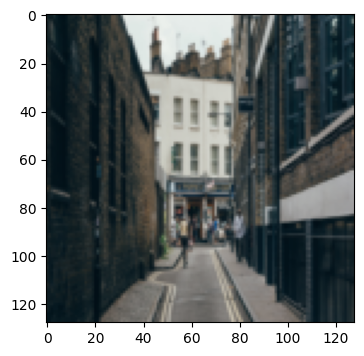

patches: torch.Size([1, 16, 3072])


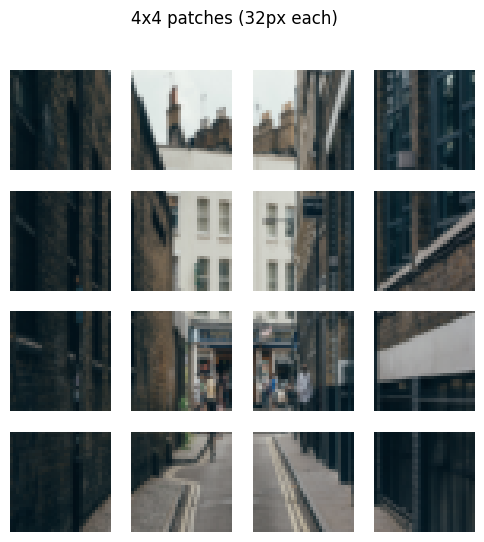

In [137]:
#Lowkey ignore this lol this is me trying to test to see if the patching is actually working with visuals.
#THIS TOOK WAY TOO FCKING LONG AAAAGH (ye i give up chatgpt go brrr help me make sure my stupid codes working)
img_size = 128
patch_size = 32
embed_dim = 128


# --- Load one example from CLIC ---
ds = tfds.load("clic", split="validation[:1]", as_supervised=False)  # load the CLIC dataset (only 1 sample from validation split)
ex = next(iter(tfds.as_numpy(ds))) # convert TF tensors -> NumPy so it can be accessed, then take the first element
arr = ex["image"]  # take the actual image instead of any other elements (like the metadata lol)

#Just reform it to 128 128 for consistency purposes
to_tensor = transforms.Compose([
    transforms.Resize((128,128)), 
    transforms.ToTensor(),    #turn into a tensor
])
img = to_tensor(Image.fromarray(arr))
x = img.unsqueeze(0)          # add batch -> (1,3,128,128)

# --- Run through PatchEmbed ---
pe = PatchEmbed(img_size=128, patch_size=32, in_chans=3, embed_dim=128)
tokens = pe(x)

print("input:", x.shape)       # (1, 3, 128, 128)
print("tokens:", tokens.shape) # (1, 16, 128)

# ---- Visualization: show original image ----
plt.figure(figsize=(4,4))
plt.imshow(img.permute(1,2,0).numpy())  # (C,H,W) -> (H,W,C)
plt.show()


#Lowkey you guys can ignore this next part i'm just testing to make sure that the image is being patched (like each patch when reverted is 32 x 32 pixels)
# ---- Raw patchify (pixels) using unfold ----
patches = F.unfold(x, kernel_size=32, stride=32)  # (B, C*p*p, N)
patches = patches.transpose(1, 2)                 # (B, N, C*p*p)

B, N, PP = patches.shape
C = x.shape[1]
p = 32
gh = gw = int((N)**0.5)  # grid = 4x4 since 128/32 = 4

print("patches:", patches.shape)  # (1, 16, 3072)

# ---- Visualize patches side by side ----
fig, axs = plt.subplots(gh, gw, figsize=(6,6))
for idx in range(N):
    patch = patches[0, idx].reshape(C, p, p).permute(1,2,0).numpy()
    r, c = divmod(idx, gw)
    axs[r, c].imshow(patch)
    axs[r, c].axis("off")

plt.suptitle(f"{gh}x{gw} patches ({p}px each)")
plt.show()


In [ ]:
# ViT for Compression
class ViTCompressor(nn.Module):
  def __init__(self, d_model, img_size, patch_size, n_channels, n_heads, n_layers):
    super().__init__()
    self.img_size = img_size
    self.patch_size = patch_size
    self.n_patches = (img_size[0] // patch_size[0]) * (img_size[1] // patch_size[1])

    self.encoder = PatchEmbed(img_size, patch_size, n_channels, d_model)
    self.pos_encoder = PositionalEncoding(self.n_patches, d_model)

    self.transformer = nn.Sequential(*[
        ViTEncoderBlock(d_model, n_heads) for _ in range(n_layers)
    ])

    # Decoder to reconstruct original patches
    self.decoder = nn.Sequential(
        nn.Linear(d_model, d_model),
        nn.ReLU(),
        nn.Linear(d_model, patch_size[0]*patch_size[1]*n_channels)
    )

    self.d_model = d_model
    self.n_channels = n_channels

  def forward(self, x):
    B = x.size(0)
    x = self.encoder(x)
    x = self.pos_encoder(x)
    x = self.transformer(x)
    x = self.decoder(x)  # (B, N_patches, patch_dim)
    x = x.transpose(1, 2).contiguous().view(
        B, self.n_channels,
        self.img_size[0] // self.patch_size[0], self.patch_size[0],
        self.img_size[1] // self.patch_size[1], self.patch_size[1]
    )

    # Rearranging patches to image
    x = x.permute(0, 1, 2, 4, 3, 5).contiguous()
    x = x.view(B, self.n_channels, self.img_size[0], self.img_size[1])
    return x
  
example = next(iter(ds))
img = example["image"]  # shape: (H, W, 3), dtype=tf.uint8

# --- 2. Convert to PyTorch tensor ---
img = np.array(img) / 255.0  # normalize to [0, 1]
img = torch.tensor(img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0)  # (1, 3, H, W)

# --- 3. Create model instance ---
d_model = 128
img_size = (img.shape[2], img.shape[3])  # (H, W)
patch_size = (32, 32)

#Crop image
H, W = img.shape[2], img.shape[3]
H = H - (H % patch_size[0])
W = W - (W % patch_size[1])
img = img[:, :, :H, :W]
img_size = (H, W)

n_channels = 3
n_heads = 4
n_layers = 2

model = ViTCompressor(d_model, img_size, patch_size, n_channels, n_heads, n_layers)

# --- 4. Run forward pass ---
with torch.no_grad():
    output = model(img)

print("Input shape:", img.shape)
print("Output shape:", output.shape)

torch.Size([1, 3, 832, 1472])
Input shape: torch.Size([1, 3, 832, 1472])
Output shape: torch.Size([1, 3, 832, 1472])
